**INTRODUCTION**

*Generative Deep Learning*

This coursework will explore the use of generative adversarial networks (GANs) to generate synthetic images of flowers. The techniques used within this study will follow the workings of Francois Chollet within the Deep Learning With Python textbook. 

GANs a class of deep learning models designed for generating new, previously unseen data that is similar to a given training dataset. GANs consist of two main components: a generator network and a discriminator network. The generator network is responsible for creating new data, while the discriminator network is responsible for distinguishing the generated data from the real data. The two networks are trained simultaneously in an adversarial manner, where the generator tries to create data that can fool the discriminator into thinking it's real, and the discriminator tries to correctly identify the generated data as fake. The training process continues until the generator is able to produce data that is indistinguishable from real data to the discriminator.

*The Dataset*

The dataset being used is the Oxford 102 Category Flower Dataset, available at https://www.robots.ox.ac.uk/~vgg/data/flowers/102/, containing 102 categories of flowers found in the UK. Each class contains between 40-258 samples with an overall sample size of 8189. To use the images within the model, they must be resized and preprocessed into a tensorflow dataset object that is normalized to squish the pixel values between 0 and 1.

*Workflow*

To successfully implement a GAN model, the tweaking of varius hyperparameters will take place along with regularization techniques in order to find the most successful model with the intent of producing the most "artistic" or "realistic" looking flower generations. This tuning process includes adjustments to the optimizer, learning rate, layer units, and number of iterations for each model.

The ultimate goal of this research is to identify the specific changes to the GAN model that result in the highest quality generated flower images, as determined by human interpretation.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import os, sys, pathlib
from PIL import Image
import tensorflow  as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU, Dropout, ZeroPadding2D, Flatten, Activation
from tensorflow.keras.optimizers import Adam

In [2]:
#Create global variables
BATCH = 64
IMG_SIZE = (64,64)
LATENT_DIM = 128
basedir = pathlib.Path("gallery") 
imgdir = basedir / "plant"     
outputdir = basedir / "generated"

In [3]:
#Importing data
batch_s = int(BATCH/2)
#Import the data and resizing to 64x64 image 
data = tf.keras.preprocessing.image_dataset_from_directory(imgdir, label_mode = None, image_size = IMG_SIZE, batch_size = batch_s, smart_resize=True).map(lambda x: x /255.0)

Found 8189 files belonging to 1 classes.


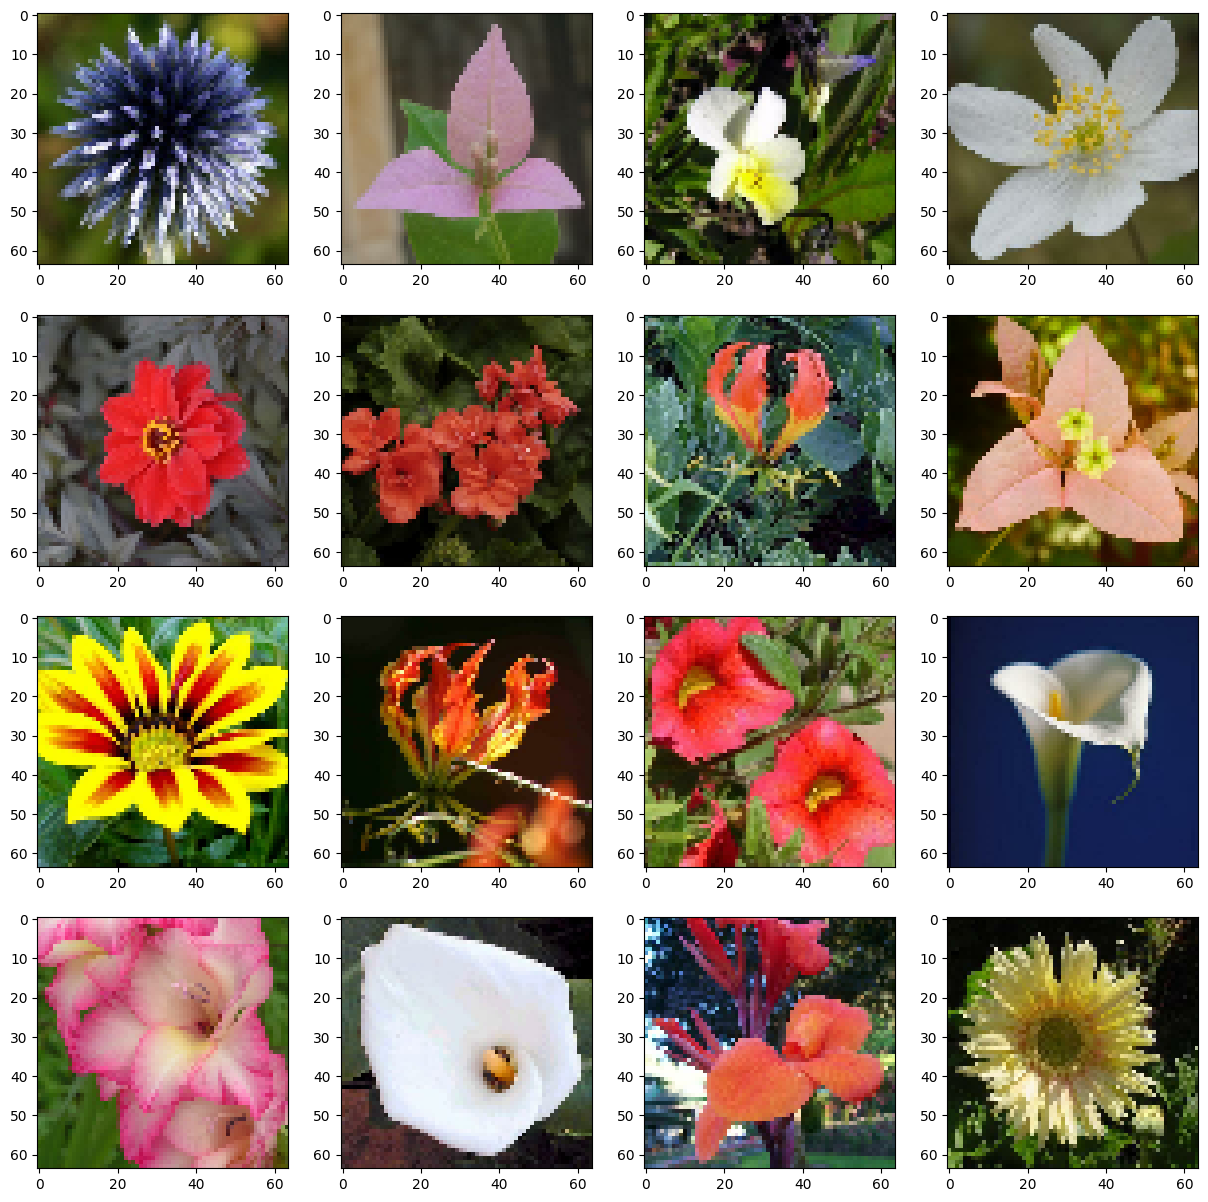

In [4]:
#Display some example images

for sample in data:
    break

f,ax = plt.subplots(4,4,figsize=(15,15))
ax=ax.flatten()
for i in range(16):
    ax[i].imshow(sample[i])

**CREATE GENERATOR / DISCRIMINATOR**

In [5]:
def create_generator(latent_dim):
  generator=Sequential()
  generator.add(Dense(4*4*512,input_shape=[latent_dim]))
  generator.add(Reshape([4,4,512]))
  generator.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization())
  generator.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization())
  generator.add(Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization())
  generator.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation='sigmoid'))
  return generator

generator = create_generator(LATENT_DIM)
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        1048704   
 nspose)                                                         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8, 8, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 128)        512       
 ormalization)                                                   
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 256)      5

In [6]:
def create_discriminator(input_shape):
  discriminator=Sequential()
  discriminator.add(Conv2D(64, kernel_size=4, strides=2, padding="same",input_shape=input_shape))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(BatchNormalization())
  discriminator.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(BatchNormalization())
  discriminator.add(Conv2D(256, kernel_size=4, strides=2, padding="same"))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Flatten())
  discriminator.add(Dropout(0.2))
  discriminator.add(Dense(1,activation='sigmoid'))
  return discriminator

input_shape = (64, 64, 3)
discriminator = create_discriminator(input_shape)
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 batch_normalization_4 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                      

**GAN CREATION**


In [11]:
class GAN(tf.keras.Model):
  def __init__(self, discriminator, generator, latent_dim):
    # Initialize the GAN model by calling the super class's constructor
    super(GAN, self).__init__()
    self.discriminator = discriminator
    self.generator = generator
    self.latent_dim = latent_dim

  def compile(self, d_optimizer, g_optimizer, loss_fn):
    # Compile the GAN model by calling the super class's compile method
    super(GAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn
    # Initialize metrics to track the losses of the discriminator and generator
    self.dloss = tf.keras.metrics.Mean(name="discriminator_loss")
    self.gloss = tf.keras.metrics.Mean(name="generator_loss")

  @property
  def metrics(self):
    # Return the list of metrics
    return [self.dloss, self.gloss]


  def train_step(self, real_images):
    # Get the batch size and generate noise with the same shape
    batch_size = tf.shape(real_images)[0]
    noise = tf.random.normal(shape=(batch_size, self.latent_dim))
    # Generate fake images
    generated_images = self.generator(noise)
    # Concatenate the fake and real images
    combined_images = tf.concat([generated_images, real_images], axis=0)
    # Create labels
    labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
    # Add some random noise to the labels to make the training more robust
    labels += 0.05 * tf.random.uniform(tf.shape(labels))
    # Use the discriminator model to predict the probability of the images being real
    with tf.GradientTape() as tape:
      predictions = self.discriminator(combined_images)
      # Calculate the loss for the discriminator
      dloss = self.loss_fn(labels, predictions)
    # Calculate the gradients for the discriminator
    grads = tape.gradient(dloss, self.discriminator.trainable_weights)
    # Update the weights of the discriminator using the optimizer
    self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
    # Generate noise with the same shape as the batch
    noise = tf.random.normal(shape=(2*batch_size, self.latent_dim))
    # Create labels of all zeros
    labels = tf.zeros((2*batch_size, 1))
    # Use the discriminator model to predict the probability of the fake images being real
    with tf.GradientTape() as tape:
      predictions = self.discriminator(self.generator(noise))
      gloss = self.loss_fn(labels, predictions)
    # Calculate the gradients for the generator
    grads = tape.gradient(gloss, self.generator.trainable_weights)
    # Update the weights of the generator using the optimizer
    self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
    # Update the loss metrics with the new losses
    self.dloss.update_state(dloss)
    self.gloss.update_state(gloss)
    # Return a dictionary with the losses of the discriminator and generator
    return {"d_loss": self.dloss.result(), "g_loss": self.gloss.result()}  

**TRAIN**

In [10]:
def train(model, epoch_number):
  
  #Create callback to monitor progress of model by showing generated images
  class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=LATENT_DIM):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = tf.keras.utils.array_to_img(generated_images[i])
            img.save(outputdir / f"generated_img_{epoch:03d}_{i}.png")

  #Code Partly Provided From Notebook 12.5

  #Fit model         
  return model.fit(data,
                    epochs = epoch_number,
                    batch_size = 512,
                    callbacks=GANMonitor(num_img=10, latent_dim=LATENT_DIM)) 


**PLOT LOSS**

In [6]:
def plot_loss():

    history_dict = history.history
    d_loss = history_dict['d_loss']
    g_loss = history_dict['g_loss']

    epochs = range(1, len(d_loss) + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'

    print('Lowest Generator Loss: ', np.argmin(g_loss))
    print('Highest Discriminator Loss: ', np.argmax(d_loss))

    plt.plot(epochs, d_loss, blue_dots, label = 'Discriminator Loss')
    plt.plot(epochs, g_loss, solid_blue_line, label = 'Generator Loss')
    plt.title('Discriminator and Generator loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

**SHOW IMAGES**

In [7]:
def show_imgs(modelz):
    f,ax = plt.subplots(3,5,figsize=(15,10))
    ax = ax.flatten()
    arr = tf.random.normal(shape=(15, LATENT_DIM))
    generated_portraits = modelz.generator(arr)
    for i in range(15):
        g=generated_portraits[i]*255
        ax[i].imshow(tf.cast(g,tf.uint8))

**SAVE / LOAD**

In [8]:
#Save Paths
generator_path = basedir / "generator_flower_gan.h5"
discriminator_path = basedir / "discriminator_flower_gan.h5"

def save():
    discriminator.save_weights(discriminator_path)          # SAVE
    generator.save_weights(generator_path)

def load():
    discriminator_reloaded = create_discriminator((64, 64, 3)) # CREATE 
    generator_reloaded = create_generator(LATENT_DIM)

    discriminator_reloaded.load_weights(discriminator_path) # LOAD WEIGHTS
    generator_reloaded.load_weights(generator_path)

    gan_reloaded = GAN(                                     # REBUILD GAN
        discriminator=discriminator_reloaded,
        generator=generator_reloaded, 
        latent_dim=LATENT_DIM
    )
    return gan_reloaded

#Code provided in notebook 12.5

In [9]:
def make_model(optimrate):
    discriminator_opt = tf.keras.optimizers.Adam(optimrate,0.5)
    generator_opt = tf.keras.optimizers.Adam(optimrate,0.5)
    loss_fn = tf.keras.losses.BinaryCrossentropy()
    model = GAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)
    model.compile(d_optimizer=discriminator_opt, g_optimizer=generator_opt, loss_fn=loss_fn)    
    return model

**Experiment 1:**

Tweaking Optimiser Adam Optimizer Learning Rate, 1.5e-5.

Training on 40 epoch (initial) followed by further 50 epoch 

In [10]:
model = make_model(1.5e-5)
history = train(model,40)

Epoch 1/40
256/256 [==============================] - 40s 125ms/step - d_loss: 0.5583 - g_loss: 0.9802
Epoch 2/40
256/256 [==============================] - 29s 113ms/step - d_loss: 0.3590 - g_loss: 1.5348
Epoch 3/40
256/256 [==============================] - 30s 116ms/step - d_loss: 0.3804 - g_loss: 1.6628
Epoch 4/40
256/256 [==============================] - 29s 111ms/step - d_loss: 0.1945 - g_loss: 2.4467
Epoch 5/40
256/256 [==============================] - 28s 109ms/step - d_loss: 0.1654 - g_loss: 3.1566
Epoch 6/40
256/256 [==============================] - 29s 112ms/step - d_loss: 0.2316 - g_loss: 2.4135
Epoch 7/40
256/256 [==============================] - 30s 116ms/step - d_loss: 0.2805 - g_loss: 2.0149
Epoch 8/40
256/256 [==============================] - 28s 108ms/step - d_loss: 0.3301 - g_loss: 1.7659
Epoch 9/40
256/256 [==============================] - 28s 110ms/step - d_loss: 0.3881 - g_loss: 1.6489
Epoch 10/40
256/256 [==============================] - 28s 110ms/step - d

Lowest Generator Loss:  37
Highest Discriminator Loss:  17


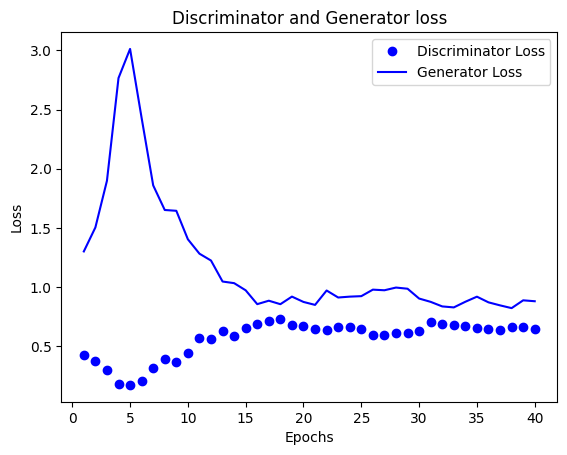

In [25]:
plot_loss()

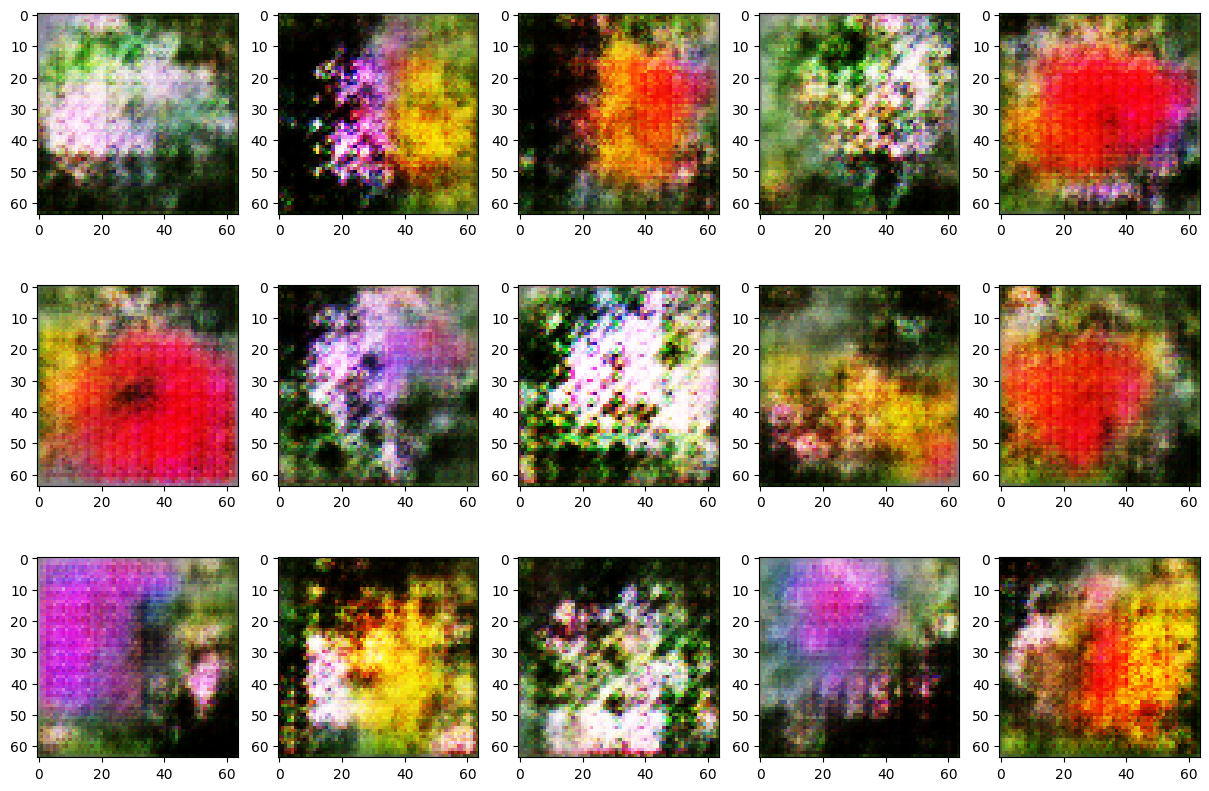

In [35]:
show_imgs(model)

**Retrain Further Epochs**


In [36]:
discriminator_opt = tf.keras.optimizers.Adam(1.5e-5,0.5)
generator_opt = tf.keras.optimizers.Adam(1.5e-5,0.5)
loss_fn = tf.keras.losses.BinaryCrossentropy()
model = load()
model.compile(d_optimizer=discriminator_opt, g_optimizer=generator_opt, loss_fn=loss_fn)

In [37]:
history = train(model,50)

Epoch 1/50
256/256 [==============================] - 29s 110ms/step - d_loss: 0.6829 - g_loss: 0.8053
Epoch 2/50
256/256 [==============================] - 25s 97ms/step - d_loss: 0.6807 - g_loss: 0.7866
Epoch 3/50
256/256 [==============================] - 25s 97ms/step - d_loss: 0.6755 - g_loss: 0.7899
Epoch 4/50
256/256 [==============================] - 28s 108ms/step - d_loss: 0.6755 - g_loss: 0.7965
Epoch 5/50
256/256 [==============================] - 25s 98ms/step - d_loss: 0.6829 - g_loss: 0.7960
Epoch 6/50
256/256 [==============================] - 28s 109ms/step - d_loss: 0.6729 - g_loss: 0.7855
Epoch 7/50
256/256 [==============================] - 29s 114ms/step - d_loss: 0.6804 - g_loss: 0.7822
Epoch 8/50
256/256 [==============================] - 30s 117ms/step - d_loss: 0.6790 - g_loss: 0.8056
Epoch 9/50
256/256 [==============================] - 31s 120ms/step - d_loss: 0.6851 - g_loss: 0.7840
Epoch 10/50
256/256 [==============================] - 30s 116ms/step - d_lo

**Model 1 Output**

Lowest Generator Loss:  32
Highest Discriminator Loss:  34


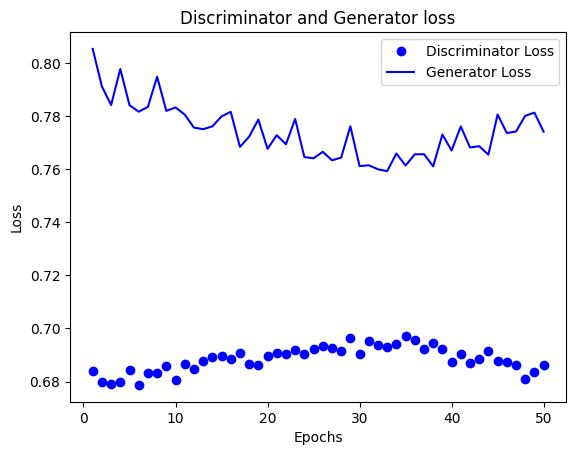

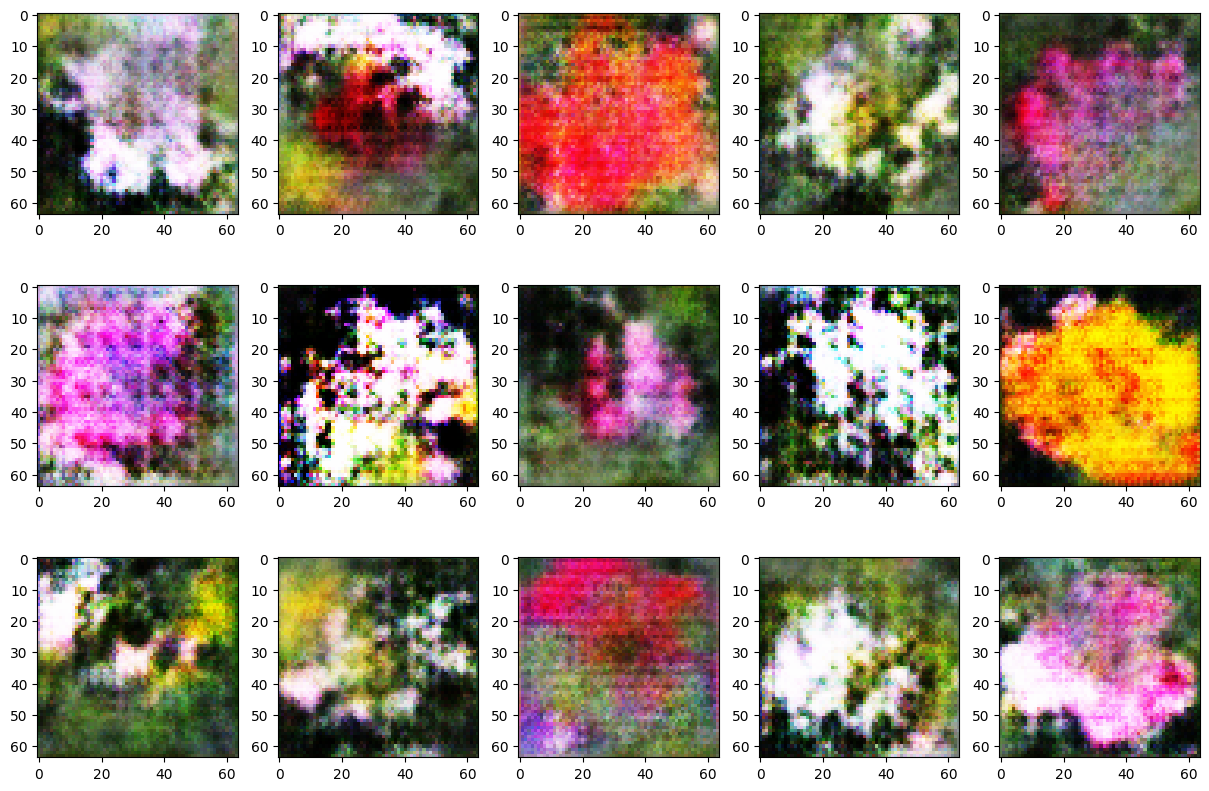

In [50]:
plot_loss()
show_imgs(model)

In [48]:
discriminator.save_weights(discriminator_path)          # SAVE
generator.save_weights(generator_path)

**Result Experiment 1:**

Training on 40 epoch (initial)

Results:
| Epoch | Discriminator Loss | Generator Loss |
| --- | --- | --- |
| 1 | 0.5583 | 0.9802 |
| 2 | 0.3590 | 1.5348 |
| 3 | 0.3804 | 1.6628 |
| 4 | 0.1945 | 2.4467 |
| 5 | 0.1654 | 3.1566 |
| 6 | 0.2316 | 2.4135 |
| 7 | 0.2805 | 2.0149 |
| 8 | 0.3301 | 1.7659 |
| 9 | 0.3881 | 1.6489 |
| 10 | 0.4590 | 1.3642 |
| 30 | 0.6279 | 0.9226 |
| 31 | 0.6518 | 0.9712 |
| 32 | 0.6944 | 0.8141 |
| 33 | 0.7003 | 0.7937 |
| 34 | 0.6823 | 0.8640 |
| 35 | 0.6424 | 0.8935 |
| 36 | 0.6399 | 0.8943 |
| 37 | 0.6404 | 0.8319 |
| 38 | 0.6531 | 0.8293 |
| 39 | 0.6526 | 0.9012 |
| 40 | 0.6621 | 0.8642 |

Further Training 50 Total Epoch:
Results:
| Epoch | Discriminator Loss | Generator Loss |
| --- | --- | --- |
| 1 | 0.6829 | 0.9802 |
| 2 | 0.6807 | 0.7866 |
| 3 | 0.6755 | 0.7899 |
| 4 | 0.6755 | 0.7965 |
| 5 | 0.6829 | 0.7960 |
| 6 | 0.6729 | 0.7855 |
| 7 | 0.6804 | 0.7822 |
| 8 | 0.6790 | 0.8056 |
| 9 | 0.6851 | 0.7840 |
| 10 | 0.6774 | 0.7929 |
| 40 | 0.6873 | 0.7605 |
| 41 | 0.6903 | 0.7693 |
| 42 | 0.6873 | 0.7714 |
| 43 | 0.6900 | 0.7663 |
| 44 | 0.6918 | 0.7644 |
| 45 | 0.6867 | 0.7795 |
| 46 | 0.6922 | 0.7680 |
| 47 | 0.6844 | 0.7706 |
| 48 | 0.6794 | 0.7805 |
| 49 | 0.6874 | 0.7659 |
| 50 | 0.6869 | 0.7696 |

The final model performance had a discriminator loss of 0.6869, which is a difference of 0.1286 from the first epoch of the initial run. On the other hand, the generator had a final value of 0.7696, with a difference of -0.2106. The discriminator loss remained relatively consistent between the final epochs, starting from the 30th to the 90th. The generator loss, however, gradually decreased across the range of epochs, indicating that further improvement is possible, albeit marginal. The final images produced were able to capture traits and patterns from the flower dataset, with many examples displaying realistic shapes and colors. A clear difference in detail can be observed between the initial image results and the final images.

**Experiment 2:**

Tweaking Optimiser Adam Optimizer Learning Rate, 2e-5.

Training on 40 epoch (initial) followed by further 50 epoch 

In [13]:
model = make_model(2e-5)
history = train(model,40)

Epoch 1/40
256/256 [==============================] - 37s 116ms/step - d_loss: 0.5402 - g_loss: 1.0413
Epoch 2/40
256/256 [==============================] - 27s 104ms/step - d_loss: 0.3876 - g_loss: 1.4123
Epoch 3/40
256/256 [==============================] - 28s 109ms/step - d_loss: 0.1702 - g_loss: 2.4356
Epoch 4/40
256/256 [==============================] - 27s 104ms/step - d_loss: 0.1549 - g_loss: 3.4074
Epoch 5/40
256/256 [==============================] - 27s 105ms/step - d_loss: 0.1523 - g_loss: 2.8311
Epoch 6/40
256/256 [==============================] - 28s 107ms/step - d_loss: 0.1884 - g_loss: 2.6452
Epoch 7/40
256/256 [==============================] - 29s 112ms/step - d_loss: 0.3844 - g_loss: 2.5068
Epoch 8/40
256/256 [==============================] - 27s 105ms/step - d_loss: 0.4915 - g_loss: 1.5771
Epoch 9/40
256/256 [==============================] - 29s 112ms/step - d_loss: 0.4941 - g_loss: 1.2908
Epoch 10/40
256/256 [==============================] - 27s 104ms/step - d

Lowest Generator Loss:  35
Highest Discriminator Loss:  35


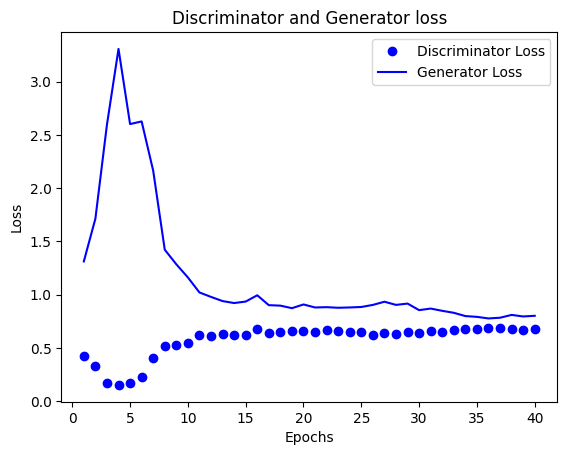

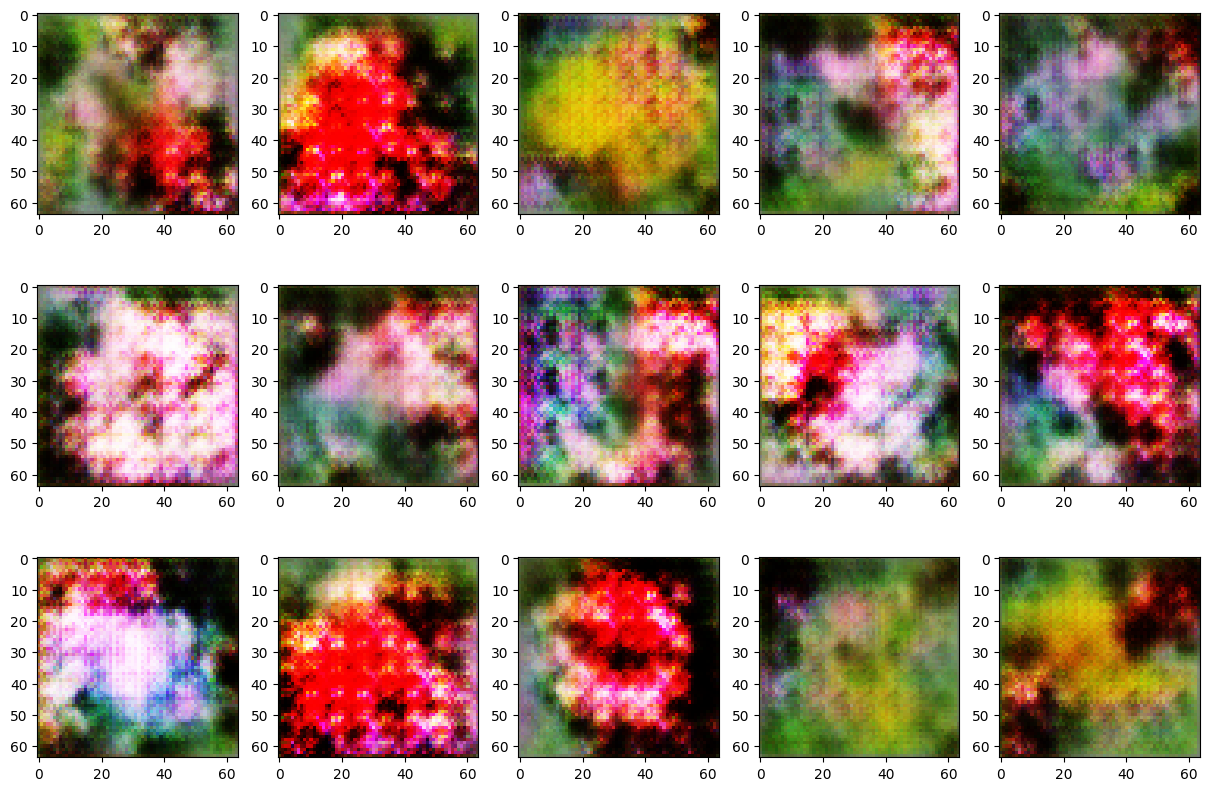

In [14]:
plot_loss()
show_imgs(model)

In [14]:
#Change Save Paths
generator_path = basedir / "generator_flower_gan_model2.h5"
discriminator_path = basedir / "discriminator_flower_gan_model2.h5"

In [ ]:
save()

In [17]:
discriminator_opt = tf.keras.optimizers.Adam(2e-5,0.5)
generator_opt = tf.keras.optimizers.Adam(2e-5,0.5)
loss_fn = tf.keras.losses.BinaryCrossentropy()
model = load()
model.compile(d_optimizer=discriminator_opt, g_optimizer=generator_opt, loss_fn=loss_fn)

**Model 2 Retrain + Results**

Epoch 1/50
256/256 [==============================] - 39s 111ms/step - d_loss: 0.6829 - g_loss: 0.8087
Epoch 2/50
256/256 [==============================] - 24s 95ms/step - d_loss: 0.6750 - g_loss: 0.8094
Epoch 3/50
256/256 [==============================] - 25s 97ms/step - d_loss: 0.6883 - g_loss: 0.7866
Epoch 4/50
256/256 [==============================] - 25s 99ms/step - d_loss: 0.6728 - g_loss: 0.8005
Epoch 5/50
256/256 [==============================] - 25s 98ms/step - d_loss: 0.6716 - g_loss: 0.8169
Epoch 6/50
256/256 [==============================] - 25s 99ms/step - d_loss: 0.6601 - g_loss: 0.8255
Epoch 7/50
256/256 [==============================] - 26s 100ms/step - d_loss: 0.6730 - g_loss: 0.8109
Epoch 8/50
256/256 [==============================] - 25s 97ms/step - d_loss: 0.6815 - g_loss: 0.7924
Epoch 9/50
256/256 [==============================] - 25s 98ms/step - d_loss: 0.6710 - g_loss: 0.7963
Epoch 10/50
256/256 [==============================] - 26s 99ms/step - d_loss: 0

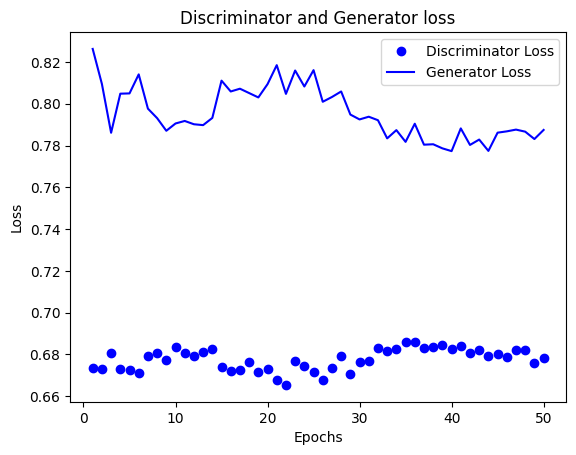

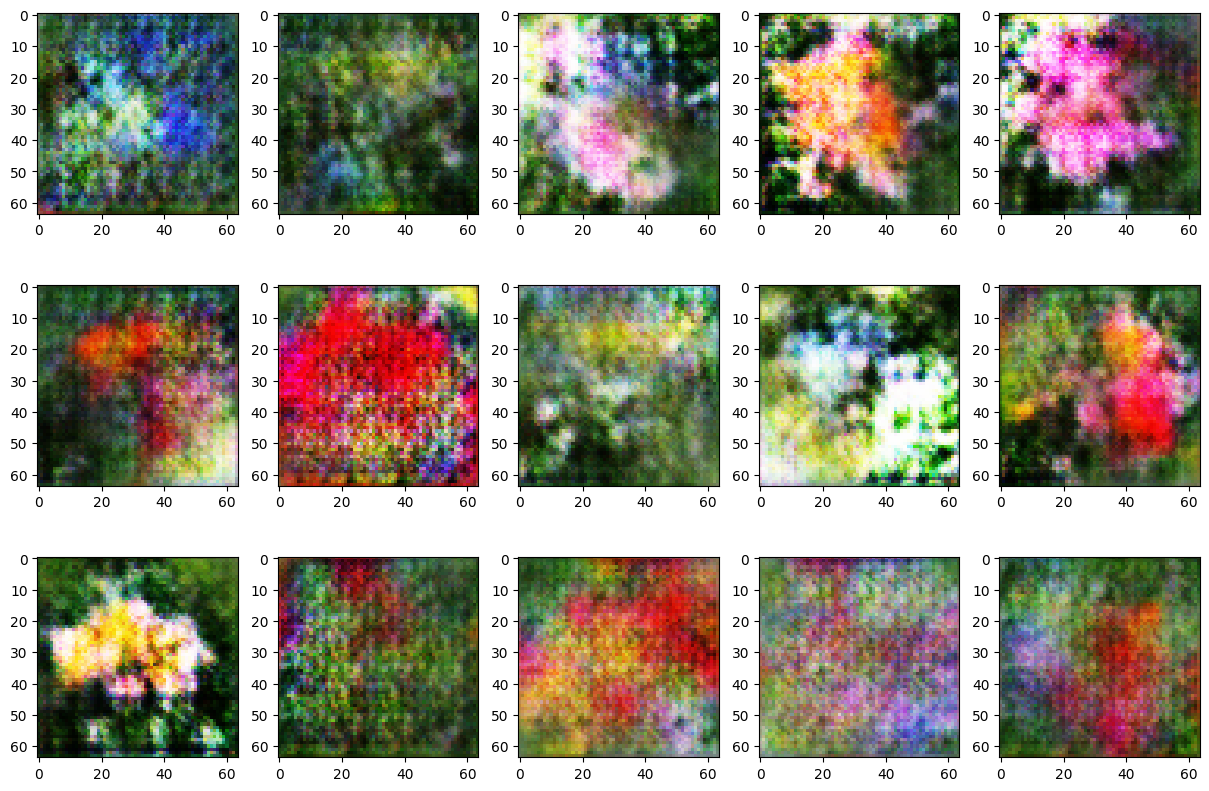

In [18]:
history = train(model,50)
plot_loss()
show_imgs(model)

**Result Experiment 2**

Results:
| Epoch | Discriminator Loss | Generator Loss |
| --- | --- | --- |
| 1 | 0.5402 | 1.0413 |
| 2 | 0.3876 | 1.4123 |
| 3 | 0.1702 | 2.4356 |
| 4 | 0.1549 | 3.4074 |
| 5 | 0.1523 | 2.8311 |
| 6 | 0.1884 | 2.6452 |
| 7 | 0.3844 | 2.5068 |
| 8 | 0.4915 | 1.5771 |
| 9 | 0.4941 | 1.2908 |
| 10 | 0.5189 | 1.2442 |
| 30 | 0.6476 | 0.8159 |
| 31 | 0.6474 | 0.9005 |
| 32 | 0.6549 | 0.8438 |
| 33 | 0.6662 | 0.8448 |
| 34 | 0.6718 | 0.8160 |
| 35 | 0.6744 | 0.8023 |
| 36 | 0.6832 | 0.7782 |
| 37 | 0.6778 | 0.7963 |
| 38 | 0.6732 | 0.8105 |
| 39 | 0.6742 | 0.7923 |
| 40 | 0.6885 | 0.8073 |

Further Training 50 Total Epoch:

Results:
| Epoch | Discriminator Loss | Generator Loss |
| --- | --- | --- |
| 1 | 0.6829 | 0.8087 |
| 2 | 0.6750 | 0.8094 |
| 3 | 0.6883 | 0.7866 |
| 4 | 0.6728 | 0.8005 |
| 5 | 0.6716 | 0.8169 |
| 6 | 0.6601 | 0.8255 |
| 7 | 0.6730 | 0.8109 |
| 8 | 0.6815 | 0.7924 |
| 9 | 0.6710 | 0.7963 |
| 10 | 0.6798 | 0.7979 |
| 40 | 0.6814 | 0.7824 |
| 41 | 0.6860 | 0.7826 |
| 42 | 0.6820 | 0.7790 |
| 43 | 0.6841 | 0.7813 |
| 44 | 0.6764 | 0.7766 |
| 45 | 0.6807 | 0.7845 |
| 46 | 0.6758 | 0.7878 |
| 47 | 0.6818 | 0.7972 |
| 48 | 0.6794 | 0.7826 |
| 49 | 0.6738 | 0.7846 |
| 50 | 0.6764 | 0.7848 |

The results of the training show that the discriminator loss of model 2 decreased from 0.5402 in the first epoch to 0.6764 in the final epoch, with a difference of 0.1362. The generator loss, on the other hand, had a larger difference compared to model 1, with a difference of -0.2565. The final results of the initial training (up to 40 epochs) were similar to the final training epoch, with only a 0.02 difference. This suggests that the model is able to achieve similar statistical results without the need for further training, resulting in a reduction in computational expense. However, there is a notable difference in the quality of the images produced by the further trained model, with a clearer image, more vibrancy, and more detail. The next experiment will involve increasing the model's capacity in an attempt to decrease and increase the loss of the GAN model at the current learning rate.

In [19]:
save()

**Experiment 3:**

Increase model capacity by doubling units of every Conv Layer from initial model by 2x. The aim is that by increasing capacity, the model will be able to extract further basic texture features within the lower layers and provide a increased definition on the produced images.

In [13]:
#Redefine the generator and discriminator

def create_generator(latent_dim):
  generator=Sequential()
  generator.add(Dense(4*4*512,input_shape=[latent_dim]))
  generator.add(Reshape([4,4,512]))
  generator.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization())
  generator.add(Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization())
  generator.add(Conv2DTranspose(1024, kernel_size=4, strides=2, padding="same"))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization())
  generator.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation='sigmoid'))
  return generator

generator = create_generator(LATENT_DIM)
generator.summary()


def create_discriminator(input_shape):
  discriminator=Sequential()
  discriminator.add(Conv2D(128, kernel_size=4, strides=2, padding="same",input_shape=input_shape))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(BatchNormalization())
  discriminator.add(Conv2D(256, kernel_size=4, strides=2, padding="same"))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(BatchNormalization())
  discriminator.add(Conv2D(512, kernel_size=4, strides=2, padding="same"))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Flatten())
  discriminator.add(Dropout(0.2))
  discriminator.add(Dense(1,activation='sigmoid'))
  return discriminator

input_shape = (64, 64, 3)
discriminator = create_discriminator(input_shape)
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 8, 8, 256)        2097408   
 ranspose)                                                       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8, 8, 256)         0         
                                                                 
 batch_normalization_5 (Batc  (None, 8, 8, 256)        1024      
 hNormalization)                                                 
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 16, 16, 512)     

In [15]:
model = make_model(2e-5)
history = train(model,40)

Epoch 1/40
256/256 [==============================] - 117s 380ms/step - d_loss: 0.4755 - g_loss: 1.2382
Epoch 2/40
256/256 [==============================] - 87s 339ms/step - d_loss: 0.3138 - g_loss: 2.0798
Epoch 3/40
256/256 [==============================] - 84s 328ms/step - d_loss: 0.1843 - g_loss: 3.1849
Epoch 4/40
256/256 [==============================] - 80s 310ms/step - d_loss: 0.3833 - g_loss: 1.8323
Epoch 5/40
256/256 [==============================] - 86s 335ms/step - d_loss: 0.6230 - g_loss: 1.2561
Epoch 6/40
256/256 [==============================] - 84s 329ms/step - d_loss: 0.6024 - g_loss: 0.9125
Epoch 7/40
256/256 [==============================] - 82s 319ms/step - d_loss: 0.5794 - g_loss: 1.0844
Epoch 8/40
256/256 [==============================] - 82s 319ms/step - d_loss: 0.6364 - g_loss: 1.0020
Epoch 9/40
256/256 [==============================] - 82s 319ms/step - d_loss: 0.6194 - g_loss: 0.9874
Epoch 10/40
256/256 [==============================] - 82s 319ms/step - 

Lowest Generator Loss:  29
Highest Discriminator Loss:  29


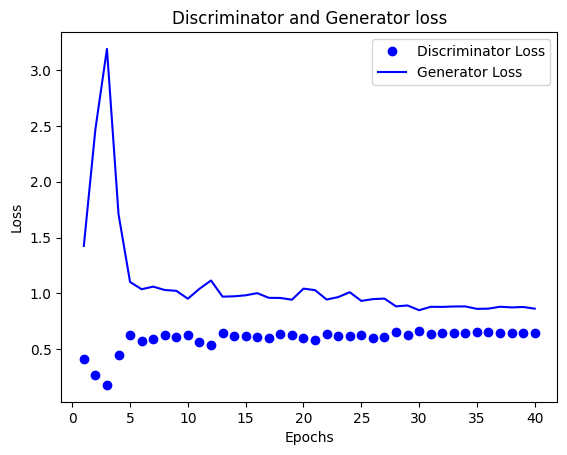

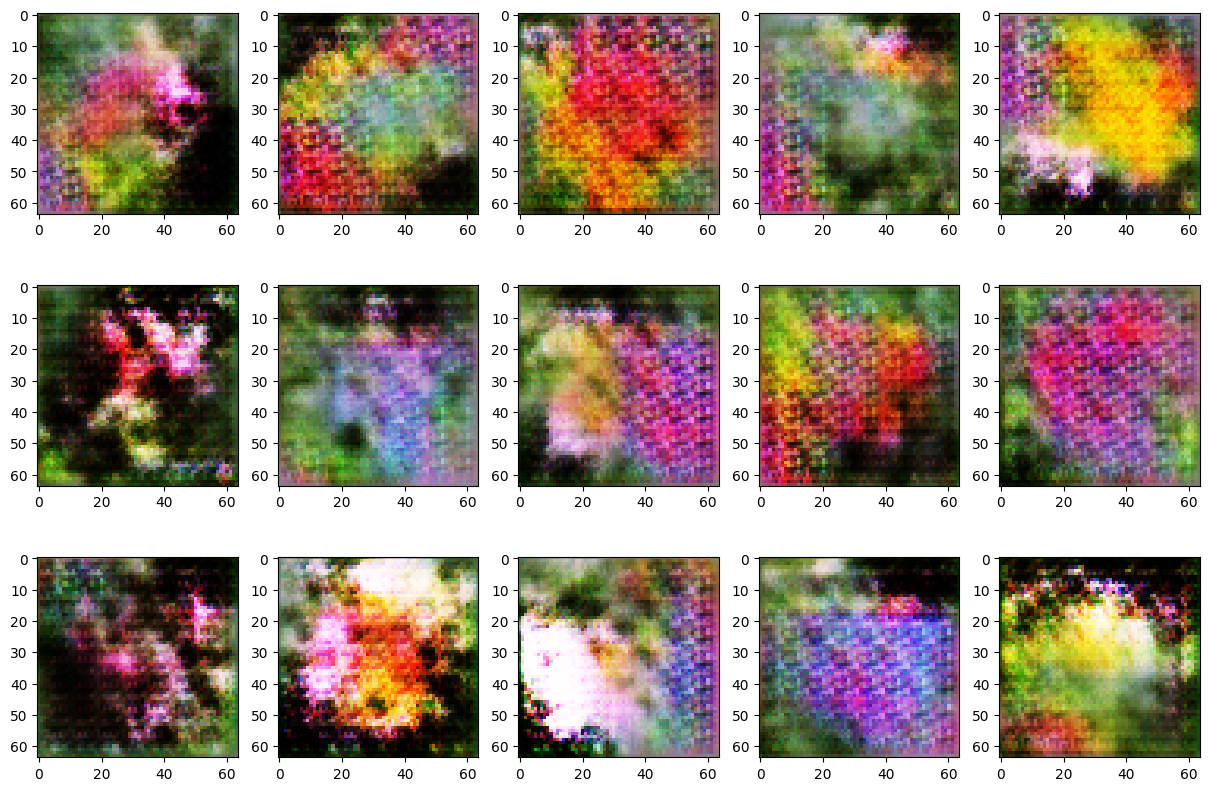

In [16]:
plot_loss()
show_imgs(model)

In [17]:
#Change Save Paths
generator_path = basedir / "generator_flower_gan_model3.h5"
discriminator_path = basedir / "discriminator_flower_gan_model3.h5"

In [18]:
save()

In [24]:
history = train(model,50)

Epoch 1/50
256/256 [==============================] - 99s 386ms/step - d_loss: 0.6408 - g_loss: 0.8936
Epoch 2/50
256/256 [==============================] - 95s 370ms/step - d_loss: 0.6446 - g_loss: 0.9056
Epoch 3/50
256/256 [==============================] - 97s 377ms/step - d_loss: 0.6472 - g_loss: 0.8713
Epoch 4/50
256/256 [==============================] - 76s 296ms/step - d_loss: 0.6455 - g_loss: 0.8673
Epoch 5/50
256/256 [==============================] - 76s 296ms/step - d_loss: 0.6494 - g_loss: 0.8639
Epoch 6/50
256/256 [==============================] - 76s 296ms/step - d_loss: 0.6593 - g_loss: 0.8419
Epoch 7/50
256/256 [==============================] - 76s 295ms/step - d_loss: 0.6599 - g_loss: 0.8535
Epoch 8/50
256/256 [==============================] - 76s 295ms/step - d_loss: 0.6635 - g_loss: 0.8274
Epoch 9/50
256/256 [==============================] - 76s 295ms/step - d_loss: 0.6702 - g_loss: 0.8275
Epoch 10/50
256/256 [==============================] - 76s 295ms/step - d

**Model 3 Outputs:**

Lowest Generator Loss:  9
Highest Discriminator Loss:  8


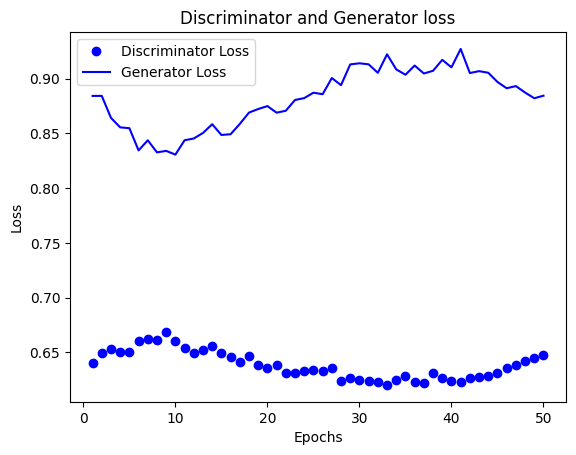

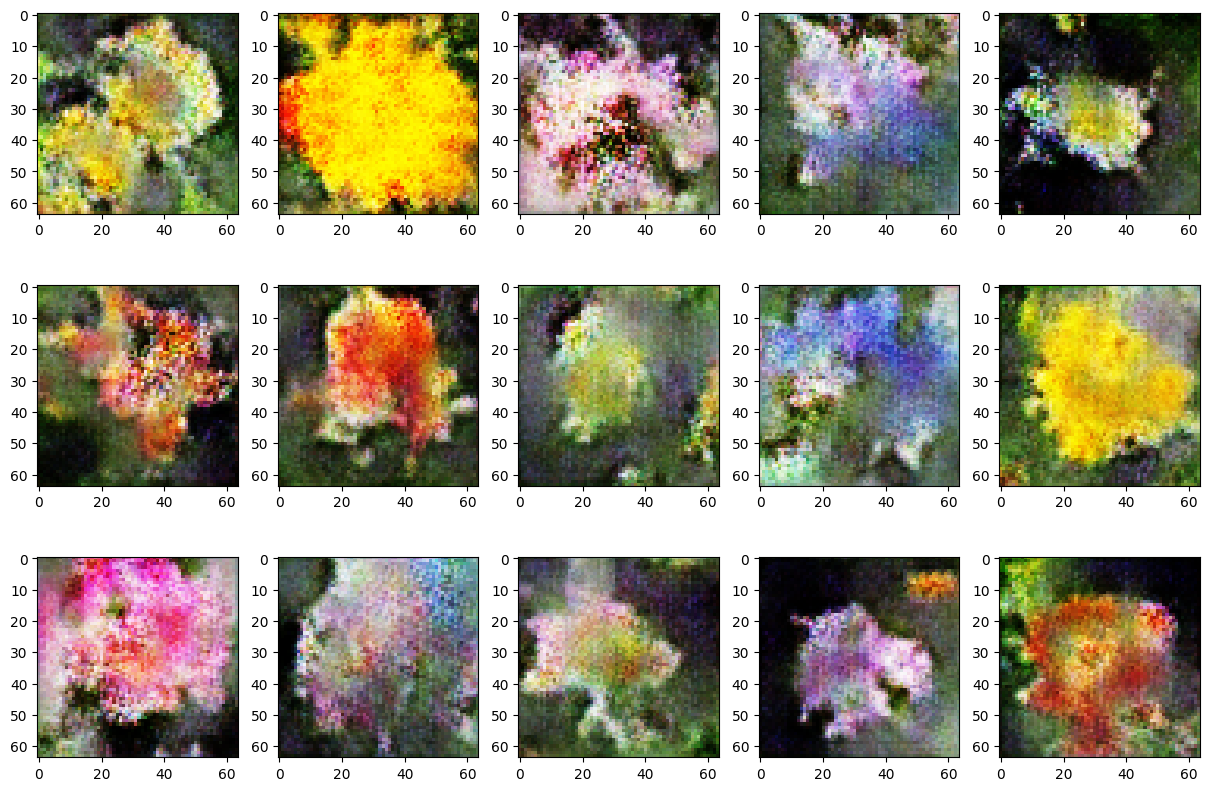

In [25]:
plot_loss()
show_imgs(model)

In [ ]:
save()

**Result Experiment 3**

The results of this experiment indicate that the loss values of the generator and discriminator did not reach the same levels as in experiment 2, with a difference of (-0.0297/+0.0935) respectively. Despite this, the final image outputs have a much clearer definition compared to experiment 2. This is likely due to the higher capacity of the model allowing for the discovery of more representative features. However, this increase in capacity also seems to have caused a generic pattern. As such, the next experiment will involve increasing the model's units as per experiment 2, but at a lower factor than in experiment 3.

**Experiment 4**

Increase model capacity of model 2 by increasing Conv2D Layers by 1.5x,

In [16]:
#Change discriminator and generator units factor of 1.5 from original 
def create_generator(latent_dim):
  generator=Sequential()
  generator.add(Dense(4*4*512,input_shape=[latent_dim]))
  generator.add(Reshape([4,4,512]))
  generator.add(Conv2DTranspose(192, kernel_size=4, strides=2, padding="same"))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization())
  generator.add(Conv2DTranspose(384, kernel_size=4, strides=2, padding="same"))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization())
  generator.add(Conv2DTranspose(758, kernel_size=4, strides=2, padding="same"))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization())
  generator.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation='sigmoid'))
  return generator

generator = create_generator(LATENT_DIM)
generator.summary()


def create_discriminator(input_shape):
  discriminator=Sequential()
  discriminator.add(Conv2D(96, kernel_size=4, strides=2, padding="same",input_shape=input_shape))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(BatchNormalization())
  discriminator.add(Conv2D(192, kernel_size=4, strides=2, padding="same"))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(BatchNormalization())
  discriminator.add(Conv2D(384, kernel_size=4, strides=2, padding="same"))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Flatten())
  discriminator.add(Dropout(0.2))
  discriminator.add(Dense(1,activation='sigmoid'))
  return discriminator

input_shape = (64, 64, 3)
discriminator = create_discriminator(input_shape)
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 8, 8, 192)        1573056   
 ranspose)                                                       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8, 8, 192)         0         
                                                                 
 batch_normalization_5 (Batc  (None, 8, 8, 192)        768       
 hNormalization)                                                 
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 16, 16, 384)     

In [12]:
model = make_model(2e-5)
history = train(model,40)

Epoch 1/40
256/256 [==============================] - 78s 254ms/step - d_loss: 0.4945 - g_loss: 1.1522
Epoch 2/40
256/256 [==============================] - 59s 230ms/step - d_loss: 0.3261 - g_loss: 1.9410
Epoch 3/40
256/256 [==============================] - 61s 238ms/step - d_loss: 0.2154 - g_loss: 2.7124
Epoch 4/40
256/256 [==============================] - 55s 216ms/step - d_loss: 0.3163 - g_loss: 2.4316
Epoch 5/40
256/256 [==============================] - 55s 215ms/step - d_loss: 0.3238 - g_loss: 1.9457
Epoch 6/40
256/256 [==============================] - 55s 216ms/step - d_loss: 0.5730 - g_loss: 1.1287
Epoch 7/40
256/256 [==============================] - 55s 216ms/step - d_loss: 0.6336 - g_loss: 1.0838
Epoch 8/40
256/256 [==============================] - 55s 216ms/step - d_loss: 0.5735 - g_loss: 1.0192
Epoch 9/40
256/256 [==============================] - 55s 216ms/step - d_loss: 0.5844 - g_loss: 1.0626
Epoch 10/40
256/256 [==============================] - 55s 216ms/step - d

Lowest Generator Loss:  27
Highest Discriminator Loss:  21


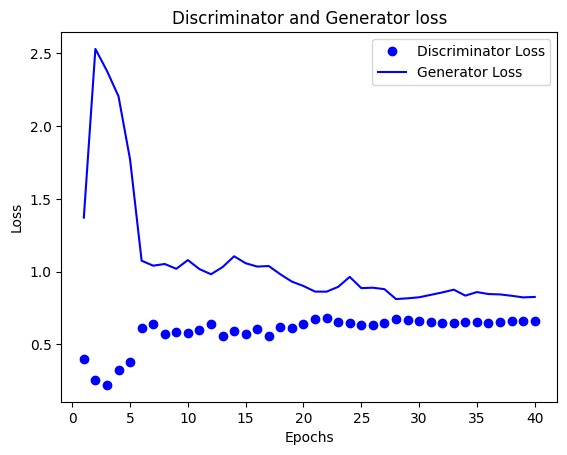

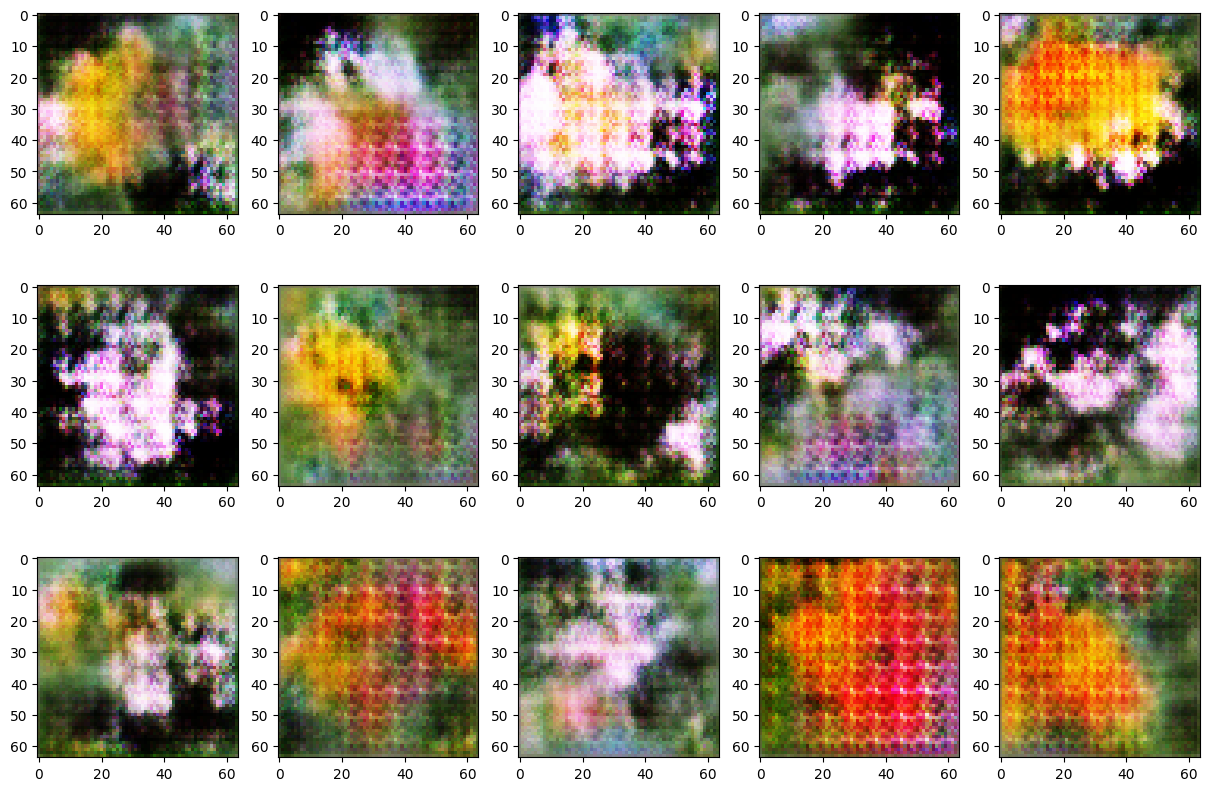

In [13]:
plot_loss()
show_imgs(model)

In [14]:
#Change Save Paths
generator_path = basedir / "generator_flower_gan_model4.h5"
discriminator_path = basedir / "discriminator_flower_gan_model4.h5"
save()

In [19]:
#Further 50 Epochs
history = train(model,50)

Epoch 1/50
256/256 [==============================] - 56s 216ms/step - d_loss: 0.6590 - g_loss: 0.8395
Epoch 2/50
256/256 [==============================] - 51s 200ms/step - d_loss: 0.6675 - g_loss: 0.8300
Epoch 3/50
256/256 [==============================] - 51s 199ms/step - d_loss: 0.6611 - g_loss: 0.8349
Epoch 4/50
256/256 [==============================] - 51s 200ms/step - d_loss: 0.6583 - g_loss: 0.8284
Epoch 5/50
256/256 [==============================] - 54s 212ms/step - d_loss: 0.6526 - g_loss: 0.8356
Epoch 6/50
256/256 [==============================] - 52s 203ms/step - d_loss: 0.6571 - g_loss: 0.8278
Epoch 7/50
256/256 [==============================] - 59s 230ms/step - d_loss: 0.6565 - g_loss: 0.8288
Epoch 8/50
256/256 [==============================] - 58s 228ms/step - d_loss: 0.6575 - g_loss: 0.8374
Epoch 9/50
256/256 [==============================] - 58s 225ms/step - d_loss: 0.6569 - g_loss: 0.8463
Epoch 10/50
256/256 [==============================] - 57s 223ms/step - d

Lowest Generator Loss:  9
Highest Discriminator Loss:  47


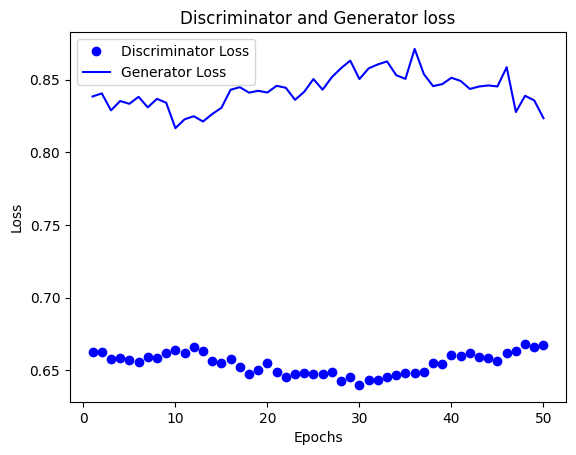

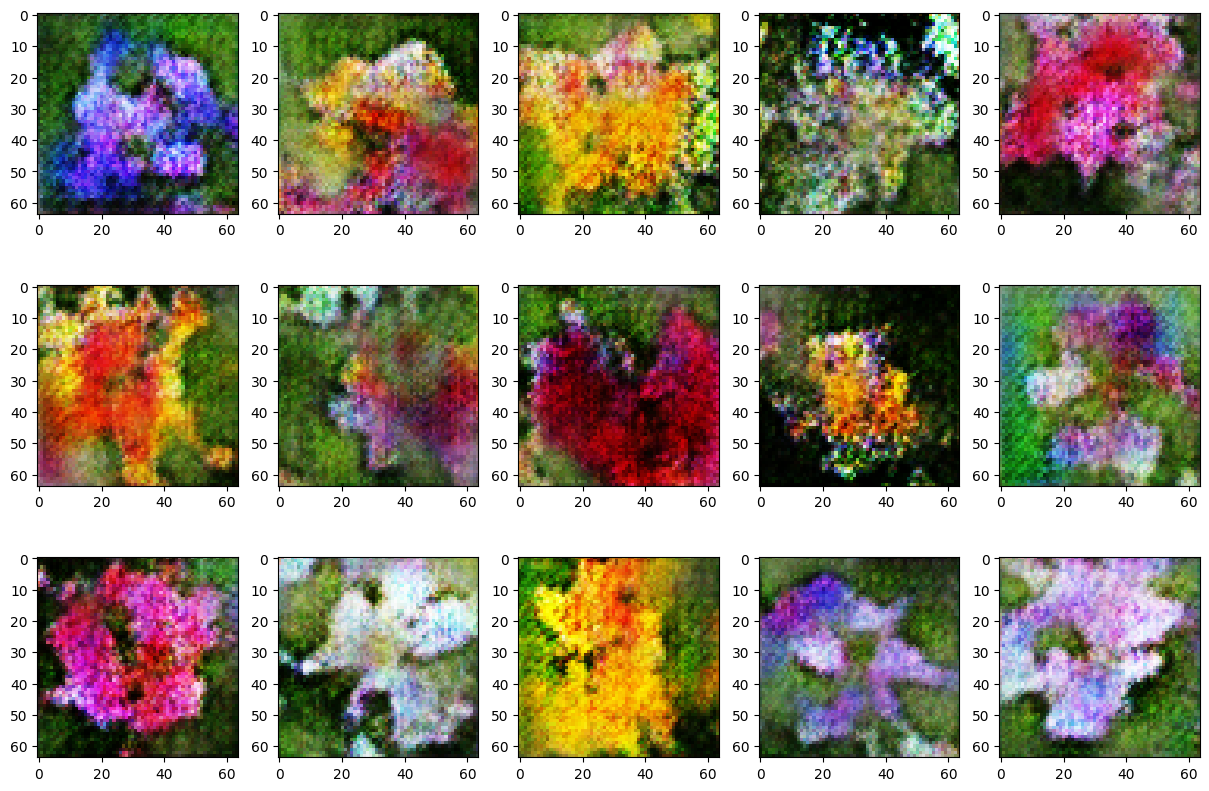

In [20]:
plot_loss()
show_imgs(model)
save()

**Results Experiment 4**

Parameter Change:
| Algorithm | Experiment 3 Trainable Parameters | Experiment 4 Trainable Parameters | Difference |
| --- | --- | --- | --- |
| Generator | 13,697,795 | 8,509,489 | 5,188,306 |
| Discriminator | 2,662,785 | 1,505,569 | 1,157216 |

3:0.6467 - g_loss: 0.8783

4:0.6669 - g_loss: 0.8196

The results of the study on the generator and discriminator indicate an improvement in performance, as evidenced by the change in loss of +0.0202/-0.0587 compared to experiment 3. Despite this improvement, the model still lacks definition and produces images with a higher level of vibrancy than the previous model. The experiment as a whole suggests that increasing the capacity of the model is necessary for achieving better image output, which is the primary focus of this investigation. This is supported by the fact that the loss values in experiment 1 were lower at (0.6669 / 0.8196) than in the current experiment.

**Experiment 5**

Alter model 3 to add L2 regularization, reload weights and train further

In [18]:
#Add L2 Regularization
from keras import regularizers

def create_generator(latent_dim):
    generator=Sequential()
    generator.add(Dense(4*4*512, input_shape=[latent_dim], kernel_regularizer=regularizers.l2(0.001)))
    generator.add(Reshape([4,4,512]))
    generator.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding="same", kernel_regularizer=regularizers.l2(0.001)))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(BatchNormalization())
    generator.add(Conv2DTranspose(512, kernel_size=4, strides=2, padding="same", kernel_regularizer=regularizers.l2(0.001)))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(BatchNormalization())
    generator.add(Conv2DTranspose(1024, kernel_size=4, strides=2, padding="same", kernel_regularizer=regularizers.l2(0.001)))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(BatchNormalization())
    generator.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)))
    return generator

generator = create_generator(LATENT_DIM)
generator.summary()



def create_discriminator(input_shape):
    discriminator=Sequential()
    discriminator.add(Conv2D(128, kernel_size=4, strides=2, padding="same",input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(BatchNormalization())
    discriminator.add(Conv2D(256, kernel_size=4, strides=2, padding="same", kernel_regularizer=regularizers.l2(0.001)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(BatchNormalization())
    discriminator.add(Conv2D(512, kernel_size=4, strides=2, padding="same", kernel_regularizer=regularizers.l2(0.001)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Flatten())
    discriminator.add(Dropout(0.2))
    discriminator.add(Dense(1,activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)))
    return discriminator

input_shape = (64, 64, 3)
discriminator = create_discriminator(input_shape)
discriminator.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 8192)              1056768   
                                                                 
 reshape_5 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_20 (Conv2D  (None, 8, 8, 256)        2097408   
 Transpose)                                                      
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 8, 8, 256)         0         
                                                                 
 batch_normalization_25 (Bat  (None, 8, 8, 256)        1024      
 chNormalization)                                                
                                                                 
 conv2d_transpose_21 (Conv2D  (None, 16, 16, 512)    

In [19]:
#Change Load Paths To Model 3
generator_path = basedir / "generator_flower_gan_model3.h5"
discriminator_path = basedir / "discriminator_flower_gan_model3.h5"
load()

In [20]:
discriminator_opt = tf.keras.optimizers.Adam(2e-5,0.5)
generator_opt = tf.keras.optimizers.Adam(2e-5,0.5)
loss_fn = tf.keras.losses.BinaryCrossentropy()
model = load()
model.compile(d_optimizer=discriminator_opt, g_optimizer=generator_opt, loss_fn=loss_fn)
history = train(model,200)

Epoch 1/200
256/256 [==============================] - 89s 344ms/step - d_loss: 0.6409 - g_loss: 0.8801
Epoch 2/200
256/256 [==============================] - 78s 303ms/step - d_loss: 0.6535 - g_loss: 0.8830
Epoch 3/200
256/256 [==============================] - 76s 296ms/step - d_loss: 0.6570 - g_loss: 0.8513
Epoch 4/200
256/256 [==============================] - 81s 314ms/step - d_loss: 0.6536 - g_loss: 0.8660
Epoch 5/200
256/256 [==============================] - 82s 321ms/step - d_loss: 0.6546 - g_loss: 0.8635
Epoch 6/200
256/256 [==============================] - 82s 320ms/step - d_loss: 0.6534 - g_loss: 0.8463
Epoch 7/200
256/256 [==============================] - 82s 321ms/step - d_loss: 0.6646 - g_loss: 0.8463
Epoch 8/200
256/256 [==============================] - 82s 321ms/step - d_loss: 0.6624 - g_loss: 0.8307
Epoch 9/200
256/256 [==============================] - 82s 321ms/step - d_loss: 0.6665 - g_loss: 0.8316
Epoch 10/200
256/256 [==============================] - 82s 321m

Lowest Generator Loss:  112
Highest Discriminator Loss:  60


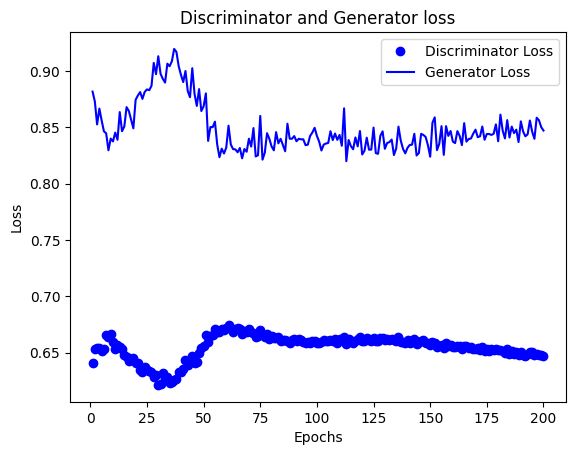

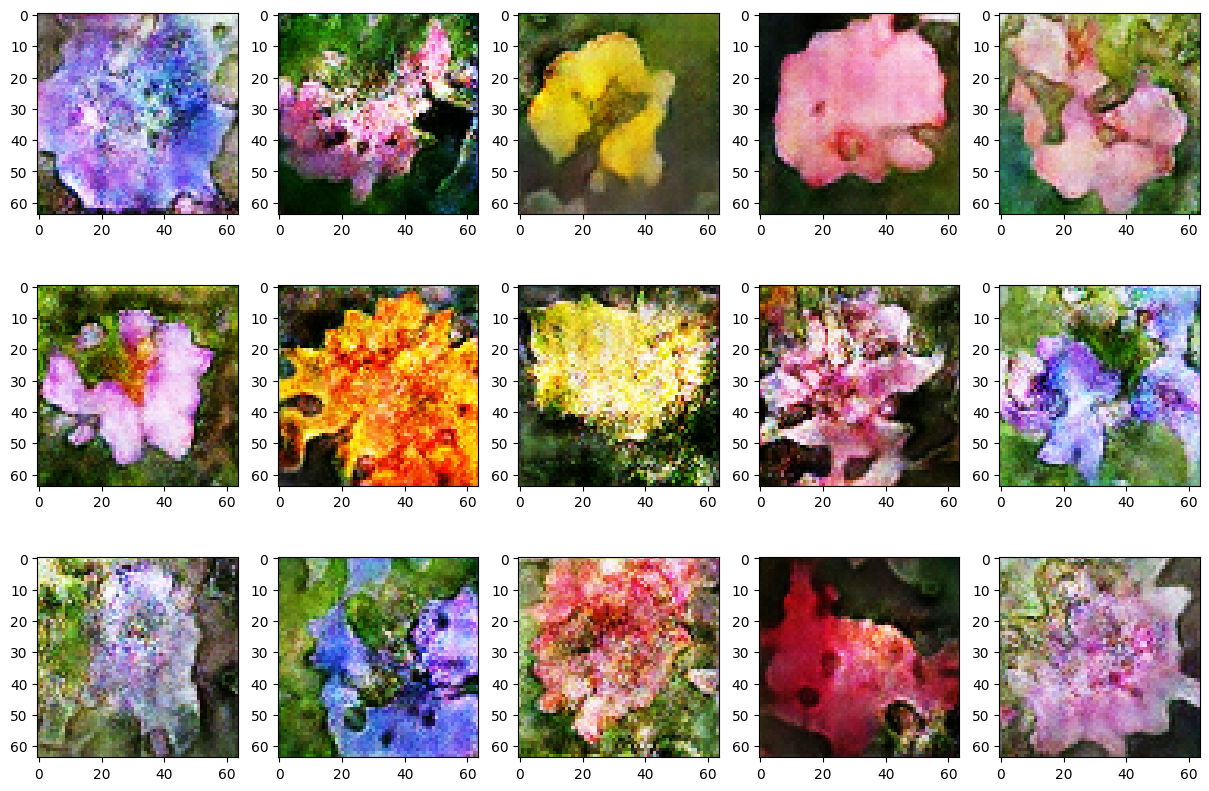

In [25]:
plot_loss()
show_imgs(model)
save()

**Results Experiment 5**

After training model 3 on a further 200 epochs, it can bee seen that the lowest generator loss was found at epoch 113 (index change) with a value of 0.8189, still higher than experiment 1/2. The outputs generated by experiment 5 provide an interesting look at the features being identified by the lower layers of the model through the generation of some rather trippy looking alien like flowers.


**Conclusion**

Throughout the course of this investigation, the objective of producing realistic flower art using GANs has been explored through the tuning of various hyperparameters, such as layer units and learning rate, as well as the application of various regularization techniques. The impact of these changes on the performance of the GAN model was evaluated through the analysis of the loss values of both the generator and discriminator, as well as the examination of the final generated images. 

It can be concluded that a comprehensive design process for GAN models has been successfully demonstrated, as evidenced by the high quality of the generated flower images and the insights gained from the experiments conducted. However, it is important to note that further experimentation is necessary to optimize the model's performance. Specifically, it is recommended to employ smaller models and to fine-tune the model's hyperparameters in order to reduce the overall loss, while also scaling up the model's capacity when appropriate.